In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

path = "/content/sample_data/AMZN (1).csv"

data = pd.read_csv(path)

In [321]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,73.260002,77.667999,73.046501,76.956497,76.956497,159662000
1,2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000
2,2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000
3,2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000
4,2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000
...,...,...,...,...,...,...,...
1262,2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100
1263,2024-01-09,148.330002,151.710007,148.210007,151.369995,151.369995,43812600
1264,2024-01-10,152.059998,154.419998,151.880005,153.729996,153.729996,44421800
1265,2024-01-11,155.039993,157.169998,153.119995,155.179993,155.179993,49072700


In [322]:
data= data[['Date', 'Close']]
data

,Date,Close
0,2019-01-02,76.956497
1,2019-01-03,75.014000
2,2019-01-04,78.769501
3,2019-01-07,81.475502
4,2019-01-08,82.829002
...,...,...
1262,2024-01-08,149.100006
1263,2024-01-09,151.369995
1264,2024-01-10,153.729996
1265,2024-01-11,155.179993


In [323]:
## device configuration
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

<ipython-input-324-bcd76b67651a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date']= pd.to_datetime(data['Date'])


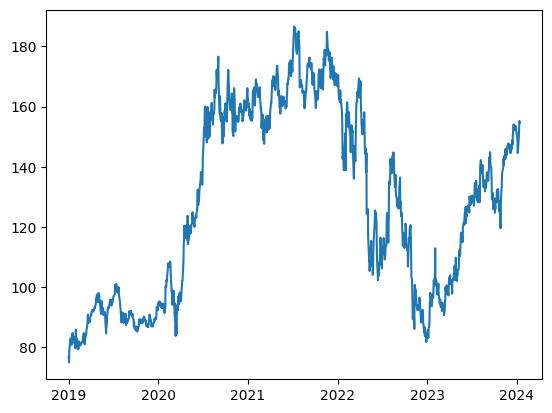

In [324]:
data['Date']= pd.to_datetime(data['Date'])
plt.plot(data['Date'] , data['Close'])

In [325]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2019-01-11,82.028000,82.810997,82.971001,82.829002,81.475502,78.769501,75.014000,76.956497
2019-01-14,80.860497,82.028000,82.810997,82.971001,82.829002,81.475502,78.769501,75.014000
2019-01-15,83.727997,80.860497,82.028000,82.810997,82.971001,82.829002,81.475502,78.769501
2019-01-16,84.189003,83.727997,80.860497,82.028000,82.810997,82.971001,82.829002,81.475502
2019-01-17,84.661003,84.189003,83.727997,80.860497,82.028000,82.810997,82.971001,82.829002
...,...,...,...,...,...,...,...,...
2024-01-08,149.100006,145.240005,144.570007,148.470001,149.929993,151.940002,153.380005,153.339996
2024-01-09,151.369995,149.100006,145.240005,144.570007,148.470001,149.929993,151.940002,153.380005
2024-01-10,153.729996,151.369995,149.100006,145.240005,144.570007,148.470001,149.929993,151.940002


In [326]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 82.028   ,  82.810997,  82.971001, ...,  78.769501,  75.014   ,
         76.956497],
       [ 80.860497,  82.028   ,  82.810997, ...,  81.475502,  78.769501,
         75.014   ],
       [ 83.727997,  80.860497,  82.028   , ...,  82.829002,  81.475502,
         78.769501],
       ...,
       [153.729996, 151.369995, 149.100006, ..., 148.470001, 149.929993,
        151.940002],
       [155.179993, 153.729996, 151.369995, ..., 144.570007, 148.470001,
        149.929993],
       [154.619995, 155.179993, 153.729996, ..., 145.240005, 144.570007,
        148.470001]])

In [327]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.95115697, -0.9365433 , -0.93355702, ..., -1.        ,
        -1.        , -0.96517465],
       [-0.97294698, -0.95115697, -0.9365433 , ..., -0.94979636,
        -0.93267087, -1.        ],
       [-0.91942862, -0.97294698, -0.95115697, ..., -0.92468528,
        -0.88415732, -0.93267087],
       ...,
       [ 0.3870725 ,  0.34302599,  0.30065944, ...,  0.29313278,
         0.34310409,  0.3791398 ],
       [ 0.41413491,  0.3870725 ,  0.34302599, ...,  0.22077734,
         0.31692915,  0.34310409],
       [ 0.40368324,  0.41413491,  0.3870725 , ...,  0.23320762,
         0.24700953,  0.31692915]])

In [328]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1260, 7), (1260,))

In [329]:
X = dc(np.flip(X, axis=1))
X

array([[-0.96517465, -1.        , -1.        , ..., -0.93620726,
        -0.93355702, -0.9365433 ],
       [-1.        , -0.93267087, -0.94979636, ..., -0.93355702,
        -0.9365433 , -0.95115697],
       [-0.93267087, -0.88415732, -0.92468528, ..., -0.9365433 ,
        -0.95115697, -0.97294698],
       ...,
       [ 0.3791398 ,  0.34310409,  0.29313278, ...,  0.22861727,
         0.30065944,  0.34302599],
       [ 0.34310409,  0.31692915,  0.22077734, ...,  0.30065944,
         0.34302599,  0.3870725 ],
       [ 0.31692915,  0.24700953,  0.23320762, ...,  0.34302599,
         0.3870725 ,  0.41413491]])

In [330]:
split_index = int(len(X) * 0.95)

split_index

1197

In [331]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1197, 7), (63, 7), (1197,), (63,))

In [332]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1197, 7, 1), (63, 7, 1), (1197, 1), (63, 1))

In [333]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1197, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1197, 1]),
 torch.Size([63, 1]))

In [334]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [335]:
train_dataset

In [336]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [337]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [338]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [339]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [340]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [341]:
learning_rate = 0.005
num_epochs = 40
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=0.001)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.015
***************************************************

Epoch: 2

Val Loss: 0.007
***************************************************

Epoch: 3

Val Loss: 0.005
***************************************************

Epoch: 4

Val Loss: 0.004
***************************************************

Epoch: 5

Val Loss: 0.004
***************************************************

Epoch: 6

Val Loss: 0.003
***************************************************

Epoch: 7

Val Loss: 0.003
***************************************************

Epoch: 8

Val Loss: 0.003
***************************************************

Epoch: 9

Val Loss: 0.003
***************************************************

Epoch: 10

Val Loss: 0.003
***************************************************

Epoch: 11

Val Loss: 0.003
***************************************************

Epoch: 12

Val Loss: 0.003
***************************************************

Epoch: 13

Val Loss: 0.003
**********************

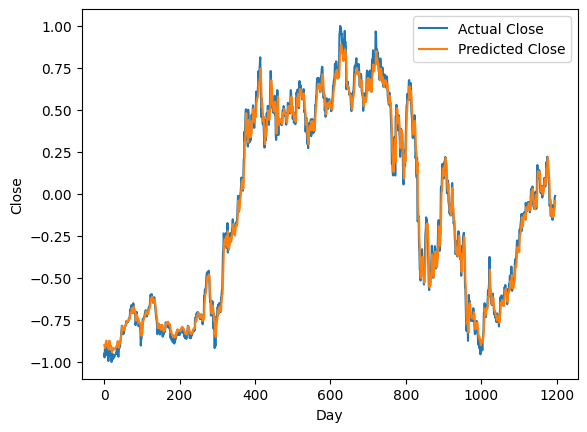

In [342]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [343]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 84.74416464,  84.45791573,  83.81997462, ..., 127.65790642,
       128.71181576, 130.68709757])

In [344]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 82.02799996,  80.8604958 ,  83.72799569, ..., 129.47999594,
       131.83000201, 132.33000198])

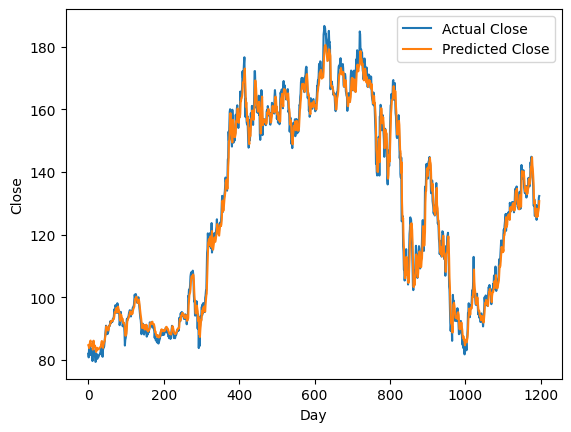

In [345]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [346]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([131.71486328, 130.33012475, 131.75134459, 131.49482891,
       129.11655289, 128.48405447, 126.04266968, 126.15264614,
       127.55717463, 123.13386055, 120.38224609, 124.98341585,
       129.98033513, 131.9796983 , 135.34738967, 137.23760431,
       138.26044629, 139.38920727, 141.76372842, 142.16691904,
       141.32705767, 143.00768101, 142.9428477 , 145.04049795,
       144.0590179 , 143.48000034, 144.82525877, 145.91097479,
       144.83051864, 146.29950678, 146.82454449, 147.65499432,
       147.49589228, 146.98251121, 146.65212193, 147.14614817,
       145.88757527, 146.78124724, 145.54623513, 146.66042051,
       147.39333934, 146.66097779, 147.44010005, 148.58484341,
       148.07449627, 149.53539023, 152.60526227, 153.52020682,
       152.82754654, 153.65228142, 153.68195636, 153.69054715,
       153.64950298, 153.6575828 , 152.76629326, 151.18567116,
       149.68935377, 146.62181625, 145.97750071, 148.23654601,
       150.4586573 , 152.71656249, 154.41318578])

In [347]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([129.78999308, 132.55000302, 131.47000095, 128.13000499,
       128.39999408, 125.16999804, 126.55999803, 128.55999792,
       121.3899991 , 119.57000059, 127.73999795, 132.71000701,
       133.089996  , 136.99999994, 138.07000703, 138.600006  ,
       139.74000526, 142.71000699, 142.08000198, 140.60000628,
       143.55999767, 142.58999623, 145.80000272, 143.19999731,
       142.83000178, 145.17999288, 146.13000477, 143.8999941 ,
       146.71000756, 146.74000506, 147.72999606, 147.02999847,
       146.32000731, 146.08999613, 147.02999847, 144.83999565,
       146.88000458, 144.52000394, 146.88000458, 147.41999793,
       145.88999921, 147.47999612, 148.83999622, 147.41999793,
       149.97000111, 154.07000772, 153.78999272, 152.11999449,
       153.83999654, 153.41999799, 153.41000361, 153.33999667,
       153.38000451, 151.94000149, 149.92999326, 148.47000149,
       144.57000696, 145.24000465, 149.1000065 , 151.36999468,
       153.72999612, 155.17999351, 154.61999544])

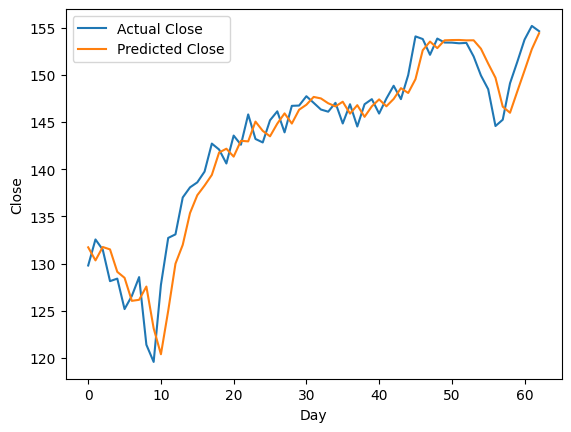

In [348]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [349]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate error and accuracy for training data
mae_train = mean_absolute_error(new_y_train, train_predictions)
rmse_train = np.sqrt(mean_squared_error(new_y_train, train_predictions))
r2_train = r2_score(new_y_train, train_predictions)

print(f'MAE (Train): {mae_train:.3f}')
print(f'RMSE (Train): {rmse_train:.3f}')
print(f'R² Score (Train): {r2_train:.3f}')

# Calculate error and accuracy for testing data
mae_test = mean_absolute_error(new_y_test, test_predictions)
rmse_test = np.sqrt(mean_squared_error(new_y_test, test_predictions))
r2_test = r2_score(new_y_test, test_predictions)

print(f'MAE (Test): {mae_test:.3f}')
print(f'RMSE (Test): {rmse_test:.3f}')
print(f'R² Score (Test): {r2_test:.3f}')

MAE (Train): 2.331
RMSE (Train): 3.160
R² Score (Train): 0.990
MAE (Test): 2.032
RMSE (Test): 2.606
R² Score (Test): 0.915
